# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices.

This notebook is part of a series intended to start from the basics to demonstrate federated learning in `pytorch`, then move on to test some of the bounds of what federated learning can (and can't) do.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. This means it does not have to deal with network communication or the timing problems inherent to parallelism. But the "local" models are independent and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Model

Now we define the model. We're using the [sample model from the `pytorch` package](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [57]:
# Define the model

import torch.nn as nn
import torch.nn.functional as F

'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

## The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms as their example.

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch it for you.

In [2]:
# acquire the data and create standard MNIST datasets

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data
data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

print("Train dataset size: ", len(train_dset))
print("Test dataset size : ", len(test_dset))

Train dataset size:  60000
Test dataset size :  10000


Now we have our standard MNIST datasets: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

In [3]:
# create dataloaders

from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dloader = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many samples of `4`s as `6`s (though the set is a *little* heavy on `1`s and a *little* light on `5`s).

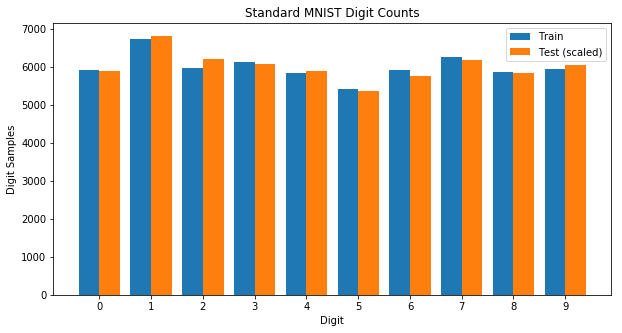

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Standard MNIST Digit Counts')
ax.set_xlabel('Digit')
ax.set_ylabel('Digit Samples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

The training data is reasonably well distributed, and the plots above confirm it. We scaled up the test set counts by a factor of six to make them comparable to the training set, which has exactly six times as many examples as the test set.

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model using just one worker (we're technically using the federated library, but with one worker, it's equivalent to non-federated learning). This one worker will train on the full standard MNIST dataset of 60,000 examples.

TODO: AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

TODO: Explain (and apologize?) the hack to measure the length of a dataset? Or find another way?

In [5]:
import federated

learning_rate = 1e-2
num_epochs = 1
num_rounds = 100

default_manager = federated.FederatedManager(
    [train_dloader],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

print("Dataset size: ", len(train_dloader.dataset))

Dataset size:  60000


In [6]:
from tqdm.notebook import trange

def run_manager(manager, num_rounds):
    
    print('Training', num_rounds, 'round(s) with', manager.n_workers, 'worker(s) doing', manager.n_epochs, 'epoch(s) per round.\n')

    for i in trange(num_rounds, desc='Rounds'):
        print('Round', i)
        manager.round()
        print(
            '\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                manager.history['test_loss'][-1],
                manager.history['test_acc'][-1] / 100,
            )
        )
        
run_manager(default_manager, num_rounds)

Training 100 round(s) with 1 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 0.1394	acc: 95.91%
	combined	loss: 0.1394	acc: 95.91%

Round 1
	wrkr 0		loss: 0.0818	acc: 97.38%
	combined	loss: 0.0818	acc: 97.38%

Round 2
	wrkr 0		loss: 0.0568	acc: 98.20%
	combined	loss: 0.0568	acc: 98.20%

Round 3
	wrkr 0		loss: 0.0470	acc: 98.34%
	combined	loss: 0.0470	acc: 98.34%

Round 4
	wrkr 0		loss: 0.0437	acc: 98.59%
	combined	loss: 0.0437	acc: 98.59%

Round 5
	wrkr 0		loss: 0.0384	acc: 98.64%
	combined	loss: 0.0384	acc: 98.64%

Round 6
	wrkr 0		loss: 0.0371	acc: 98.67%
	combined	loss: 0.0371	acc: 98.67%

Round 7
	wrkr 0		loss: 0.0350	acc: 98.81%
	combined	loss: 0.0350	acc: 98.81%

Round 8
	wrkr 0		loss: 0.0339	acc: 98.79%
	combined	loss: 0.0339	acc: 98.79%

Round 9
	wrkr 0		loss: 0.0325	acc: 98.80%
	combined	loss: 0.0325	acc: 98.80%

Round 10
	wrkr 0		loss: 0.0311	acc: 98.89%
	combined	loss: 0.0311	acc: 98.89%

Round 11
	wrkr 0		loss: 0.0299	acc: 98.94%
	combined	loss: 0.0299	acc: 98.94%

Round 12
	wrkr 0		loss: 0.0298	acc: 98.94%
	combined	loss: 0.0

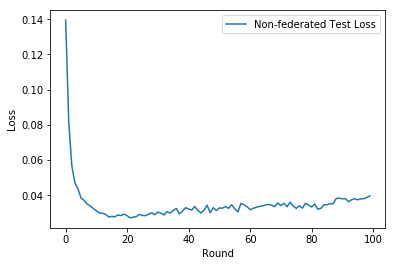

In [7]:
fig_default, ax_default = plt.subplots()

ax_default.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax_default.set_xlabel("Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

# The Federated Approach

Now that we have a baseline using the traditional approach. we perform the same task using the federated learning approach.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a device in the field. For now, we'll assume our workers are exposed to similar types and amounts of data, say, a thermostat reporting temperature and humidity every ten minutes. The analog here in MNIST is a subset of training examples for each worker. Here, we'll use ten workers. Our `pytorch` implementation will create a training `DataLoader` for each worker (and we we'll leave the test `DataLoader` as it is in the raw MNIST `Dataset`.

In [8]:
#from torch.utils.data import WeightedRandomSampler
#whitmans_sampler = WeightedRandomSampler([0.2, 0.14, 0.19], 24, replacement=False)

from torch.utils.data import RandomSampler

num_workers = 10
samples_per_worker = 6000
fed_constant_n_dloaders = []

fed_constant_n_sampler = RandomSampler(
    data_source=train_dset,
    replacement= True,
    num_samples=samples_per_worker,
    )

for i in trange(num_workers):
    fed_constant_n_dloaders.append(DataLoader(
        train_dset, 
        batch_size=train_batch_size, 
        sampler=fed_constant_n_sampler,
    ))

In [9]:
for i in trange(len(fed_constant_n_dloaders), desc='Checking Dataloader Sizes: '):
    _, ybatches = list(zip(*fed_constant_n_dloaders[7]))
    print('Dataloader', i, 'sample count:', len(torch.cat(ybatches)))

Dataloader 0 sample count: 6000
Dataloader 1 sample count: 6000
Dataloader 2 sample count: 6000
Dataloader 3 sample count: 6000
Dataloader 4 sample count: 6000
Dataloader 5 sample count: 6000
Dataloader 6 sample count: 6000
Dataloader 7 sample count: 6000
Dataloader 8 sample count: 6000
Dataloader 9 sample count: 6000



In [10]:
from collections import Counter
import numpy as np
from tqdm.notebook import tqdm

hist_counts = []
digit_counts = []
for loader in tqdm(fed_constant_n_dloaders, desc='Getting Digit Counts:'):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

In [11]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(digit_counts)

print(fed_constant_n_dloaders[0].dataset.__len__)

for i in range(len(fed_constant_n_dloaders)):
    
    print(sum(digit_counts[i]))
    

[   [588, 576, 649, 622, 558, 592, 592, 549, 608, 625],
    [685, 692, 632, 639, 646, 667, 692, 706, 665, 711],
    [590, 607, 583, 598, 613, 590, 600, 605, 564, 564],
    [577, 608, 615, 605, 629, 596, 587, 594, 625, 631],
    [604, 573, 612, 597, 589, 579, 585, 547, 591, 578],
    [546, 530, 556, 533, 528, 571, 559, 554, 531, 531],
    [604, 592, 583, 575, 627, 633, 604, 622, 598, 618],
    [599, 627, 605, 658, 618, 612, 615, 653, 622, 632],
    [604, 614, 589, 552, 596, 595, 552, 589, 596, 554],
    [603, 581, 576, 621, 596, 565, 614, 581, 600, 556]]
<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./MNIST-data/raw
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None>
5959
6735
5914
6067
5855
5439
6056
6241
5841
5893


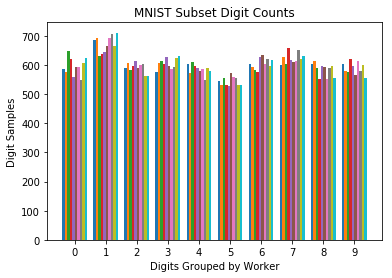

In [12]:
fig, ax = plt.subplots()
ax.set_title('MNIST Subset Digit Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylabel('Digit Samples')
ax.set_xlabel('Digits Grouped by Worker')
H = ax.hist(hist_counts, bins=range(11), histtype='bar', align='left', rwidth=0.8)


##TODO CONFIRM WHAT IM SEEING HERE

So we can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

In [13]:
fed_constant_n_manager = federated.FederatedManager(
    fed_constant_n_dloaders,
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_constant_n_manager, num_rounds)

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 0.3994	acc: 88.90%
	wrkr 1		loss: 0.4174	acc: 88.22%
	wrkr 2		loss: 0.3933	acc: 89.30%
	wrkr 3		loss: 0.4005	acc: 88.12%
	wrkr 4		loss: 0.4000	acc: 89.60%
	wrkr 5		loss: 0.3912	acc: 89.26%
	wrkr 6		loss: 0.4089	acc: 88.17%
	wrkr 7		loss: 0.3773	acc: 89.25%
	wrkr 8		loss: 0.4051	acc: 88.76%
	wrkr 9		loss: 0.4285	acc: 88.37%
	combined	loss: 0.3731	acc: 90.05%

Round 1
	wrkr 0		loss: 0.2934	acc: 91.42%
	wrkr 1		loss: 0.2975	acc: 91.19%
	wrkr 2		loss: 0.3133	acc: 91.11%
	wrkr 3		loss: 0.3161	acc: 90.93%
	wrkr 4		loss: 0.3110	acc: 90.74%
	wrkr 5		loss: 0.3244	acc: 90.30%
	wrkr 6		loss: 0.3034	acc: 91.13%
	wrkr 7		loss: 0.3248	acc: 90.00%
	wrkr 8		loss: 0.2954	acc: 91.32%
	wrkr 9		loss: 0.3100	acc: 90.97%
	combined	loss: 0.2742	acc: 92.15%

Round 2
	wrkr 0		loss: 0.2647	acc: 91.78%
	wrkr 1		loss: 0.2660	acc: 92.08%
	wrkr 2		loss: 0.2524	acc: 92.37%
	wrkr 3		loss: 0.2587	acc: 92.09%
	wrkr 4		loss: 0.2523	acc: 92.48%
	wrkr 5		loss: 0.2557	acc: 92.63%
	wrkr 6		loss: 0.249

	wrkr 4		loss: 0.0903	acc: 97.31%
	wrkr 5		loss: 0.0885	acc: 97.29%
	wrkr 6		loss: 0.0879	acc: 97.35%
	wrkr 7		loss: 0.0926	acc: 97.21%
	wrkr 8		loss: 0.0921	acc: 97.08%
	wrkr 9		loss: 0.0873	acc: 97.44%
	combined	loss: 0.0827	acc: 97.42%

Round 22
	wrkr 0		loss: 0.0886	acc: 97.26%
	wrkr 1		loss: 0.0873	acc: 97.36%
	wrkr 2		loss: 0.0847	acc: 97.43%
	wrkr 3		loss: 0.0857	acc: 97.30%
	wrkr 4		loss: 0.0847	acc: 97.43%
	wrkr 5		loss: 0.0854	acc: 97.48%
	wrkr 6		loss: 0.0933	acc: 97.29%
	wrkr 7		loss: 0.0886	acc: 97.27%
	wrkr 8		loss: 0.0885	acc: 97.40%
	wrkr 9		loss: 0.0909	acc: 97.41%
	combined	loss: 0.0797	acc: 97.67%

Round 23
	wrkr 0		loss: 0.0858	acc: 97.39%
	wrkr 1		loss: 0.0818	acc: 97.42%
	wrkr 2		loss: 0.0846	acc: 97.43%
	wrkr 3		loss: 0.0842	acc: 97.47%
	wrkr 4		loss: 0.0859	acc: 97.36%
	wrkr 5		loss: 0.0856	acc: 97.30%
	wrkr 6		loss: 0.0910	acc: 97.17%
	wrkr 7		loss: 0.0823	acc: 97.54%
	wrkr 8		loss: 0.0865	acc: 97.28%
	wrkr 9		loss: 0.0855	acc: 97.39%
	combined	loss: 0.0775	acc

	wrkr 8		loss: 0.0581	acc: 98.19%
	wrkr 9		loss: 0.0532	acc: 98.41%
	combined	loss: 0.0506	acc: 98.48%

Round 43
	wrkr 0		loss: 0.0542	acc: 98.38%
	wrkr 1		loss: 0.0592	acc: 98.16%
	wrkr 2		loss: 0.0526	acc: 98.36%
	wrkr 3		loss: 0.0572	acc: 98.21%
	wrkr 4		loss: 0.0554	acc: 98.35%
	wrkr 5		loss: 0.0604	acc: 98.15%
	wrkr 6		loss: 0.0512	acc: 98.35%
	wrkr 7		loss: 0.0574	acc: 98.15%
	wrkr 8		loss: 0.0528	acc: 98.39%
	wrkr 9		loss: 0.0537	acc: 98.26%
	combined	loss: 0.0494	acc: 98.50%

Round 44
	wrkr 0		loss: 0.0524	acc: 98.43%
	wrkr 1		loss: 0.0545	acc: 98.29%
	wrkr 2		loss: 0.0528	acc: 98.30%
	wrkr 3		loss: 0.0587	acc: 98.18%
	wrkr 4		loss: 0.0530	acc: 98.43%
	wrkr 5		loss: 0.0556	acc: 98.26%
	wrkr 6		loss: 0.0527	acc: 98.39%
	wrkr 7		loss: 0.0555	acc: 98.27%
	wrkr 8		loss: 0.0556	acc: 98.21%
	wrkr 9		loss: 0.0592	acc: 98.17%
	combined	loss: 0.0491	acc: 98.46%

Round 45
	wrkr 0		loss: 0.0544	acc: 98.27%
	wrkr 1		loss: 0.0544	acc: 98.25%
	wrkr 2		loss: 0.0517	acc: 98.43%
	wrkr 3		loss: 

	wrkr 0		loss: 0.0446	acc: 98.62%
	wrkr 1		loss: 0.0475	acc: 98.52%
	wrkr 2		loss: 0.0457	acc: 98.54%
	wrkr 3		loss: 0.0460	acc: 98.55%
	wrkr 4		loss: 0.0444	acc: 98.50%
	wrkr 5		loss: 0.0419	acc: 98.55%
	wrkr 6		loss: 0.0438	acc: 98.62%
	wrkr 7		loss: 0.0436	acc: 98.64%
	wrkr 8		loss: 0.0463	acc: 98.50%
	wrkr 9		loss: 0.0417	acc: 98.68%
	combined	loss: 0.0397	acc: 98.74%

Round 65
	wrkr 0		loss: 0.0425	acc: 98.68%
	wrkr 1		loss: 0.0416	acc: 98.71%
	wrkr 2		loss: 0.0435	acc: 98.51%
	wrkr 3		loss: 0.0453	acc: 98.44%
	wrkr 4		loss: 0.0439	acc: 98.55%
	wrkr 5		loss: 0.0437	acc: 98.62%
	wrkr 6		loss: 0.0429	acc: 98.59%
	wrkr 7		loss: 0.0466	acc: 98.62%
	wrkr 8		loss: 0.0454	acc: 98.50%
	wrkr 9		loss: 0.0449	acc: 98.52%
	combined	loss: 0.0398	acc: 98.74%

Round 66
	wrkr 0		loss: 0.0426	acc: 98.59%
	wrkr 1		loss: 0.0438	acc: 98.64%
	wrkr 2		loss: 0.0426	acc: 98.61%
	wrkr 3		loss: 0.0454	acc: 98.53%
	wrkr 4		loss: 0.0434	acc: 98.56%
	wrkr 5		loss: 0.0453	acc: 98.56%
	wrkr 6		loss: 0.0442	acc:

	wrkr 4		loss: 0.0369	acc: 98.85%
	wrkr 5		loss: 0.0382	acc: 98.83%
	wrkr 6		loss: 0.0383	acc: 98.77%
	wrkr 7		loss: 0.0382	acc: 98.75%
	wrkr 8		loss: 0.0396	acc: 98.66%
	wrkr 9		loss: 0.0386	acc: 98.79%
	combined	loss: 0.0347	acc: 98.86%

Round 86
	wrkr 0		loss: 0.0379	acc: 98.81%
	wrkr 1		loss: 0.0369	acc: 98.85%
	wrkr 2		loss: 0.0383	acc: 98.73%
	wrkr 3		loss: 0.0419	acc: 98.65%
	wrkr 4		loss: 0.0377	acc: 98.74%
	wrkr 5		loss: 0.0384	acc: 98.73%
	wrkr 6		loss: 0.0391	acc: 98.74%
	wrkr 7		loss: 0.0369	acc: 98.80%
	wrkr 8		loss: 0.0413	acc: 98.62%
	wrkr 9		loss: 0.0410	acc: 98.72%
	combined	loss: 0.0356	acc: 98.84%

Round 87
	wrkr 0		loss: 0.0383	acc: 98.69%
	wrkr 1		loss: 0.0394	acc: 98.72%
	wrkr 2		loss: 0.0407	acc: 98.69%
	wrkr 3		loss: 0.0386	acc: 98.75%
	wrkr 4		loss: 0.0371	acc: 98.78%
	wrkr 5		loss: 0.0410	acc: 98.69%
	wrkr 6		loss: 0.0387	acc: 98.68%
	wrkr 7		loss: 0.0387	acc: 98.81%
	wrkr 8		loss: 0.0372	acc: 98.84%
	wrkr 9		loss: 0.0382	acc: 98.77%
	combined	loss: 0.0347	acc

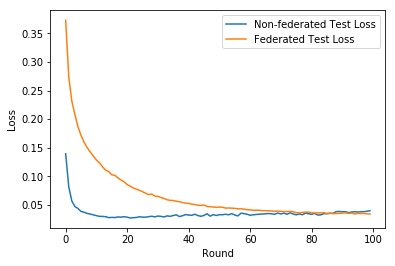

In [14]:
fig, ax = plt.subplots()

ax.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax.plot(fed_constant_n_manager.history['test_loss'], label="Federated Test Loss")

ax.set_xlabel("Round")
ax.set_ylabel("Loss")
ax.legend();

100
100
100
100


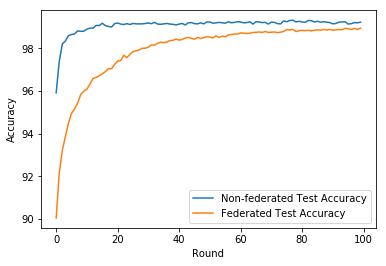

In [19]:
fig, ax = plt.subplots()

ax.plot(default_manager.history['test_acc'], label="Non-federated Test Accuracy")

ax.plot(fed_constant_n_manager.history['test_acc'], label="Federated Test Accuracy")

ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.legend();

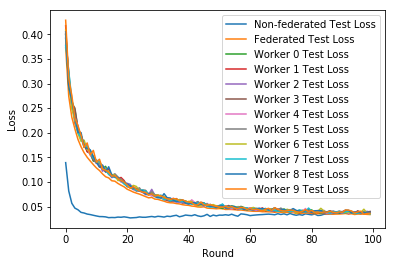

In [16]:
fig, ax = plt.subplots()

ax.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax.plot(fed_constant_n_manager.history['test_loss'], label="Federated Test Loss")

for w in fed_constant_n_manager.workers:
    ax.plot(w.history['test_loss'], label=('Worker ' + str(w.name) + ' Test Loss'))

ax.set_xlabel("Round")
ax.set_ylabel("Loss")
ax.legend();

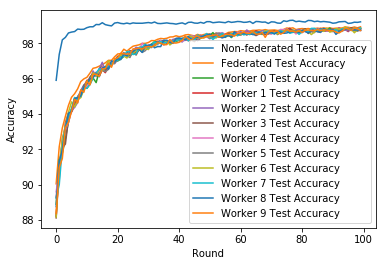

In [18]:
fig, ax = plt.subplots()

ax.plot(default_manager.history['test_acc'], label="Non-federated Test Accuracy")

ax.plot(fed_constant_n_manager.history['test_acc'], label="Federated Test Accuracy")

for w in fed_constant_n_manager.workers:
    ax.plot(w.history['test_acc'], label=('Worker ' + str(w.name) + ' Test Accuracy'))

ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.legend();

TODO: WHAT DID WE SEE??!?!?!!eleventy!

# Federation with Varying Example Counts

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Deck into Uneven Piles

To test this, we need workers to have access to different numbers of training examples. So let's make a set of decks that gives each of our workers more or less training data than the others.

# EVERYTHING BELOW HERE IS SANDBOX

In [35]:
import federated_mnist as fm

stacked_dsets = fm.make_stacked_dsets(train_dset, p=0.3)
fm.check_dsets(stacked_dsets)

Distributions
Counter({0: 1802, 1: 520, 7: 496, 3: 490, 9: 467, 6: 467, 4: 455, 8: 441, 5: 424, 2: 406})
Counter({1: 2027, 7: 487, 2: 478, 9: 477, 3: 460, 8: 458, 6: 448, 0: 440, 4: 435, 5: 410})
Counter({2: 1844, 1: 533, 4: 510, 3: 483, 7: 480, 6: 473, 5: 448, 9: 444, 0: 440, 8: 424})
Counter({3: 1827, 1: 533, 7: 503, 0: 476, 6: 455, 9: 446, 8: 443, 2: 433, 4: 414, 5: 365})
Counter({4: 1814, 1: 528, 7: 506, 9: 501, 3: 469, 6: 457, 5: 456, 0: 452, 2: 447, 8: 426})
Counter({5: 1645, 1: 517, 3: 499, 6: 478, 8: 478, 0: 462, 9: 454, 7: 449, 4: 447, 2: 420})
Counter({6: 1765, 1: 544, 8: 514, 2: 509, 7: 497, 9: 484, 0: 455, 3: 449, 4: 432, 5: 414})
Counter({7: 1856, 2: 511, 1: 510, 3: 498, 6: 474, 0: 463, 9: 448, 8: 434, 4: 432, 5: 420})
Counter({8: 1777, 1: 531, 0: 512, 7: 487, 3: 481, 4: 465, 9: 462, 6: 456, 2: 443, 5: 413})
Counter({9: 1766, 7: 504, 1: 499, 3: 475, 2: 467, 8: 456, 6: 445, 4: 438, 5: 426, 0: 421})


In [38]:
fed_stk_dloaders = [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in stacked_dsets]

fed_stk_mgr = federated.FederatedManager(
    fed_stk_dloaders,
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk_mgr, num_rounds)

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 1.3456	acc: 69.69%
	wrkr 1		loss: 1.3057	acc: 72.69%
	wrkr 2		loss: 1.2730	acc: 72.65%
	wrkr 3		loss: 1.3237	acc: 66.33%
	wrkr 4		loss: 1.2317	acc: 69.80%
	wrkr 5		loss: 1.3152	acc: 69.12%
	wrkr 6		loss: 1.2495	acc: 72.77%
	wrkr 7		loss: 1.2557	acc: 72.42%
	wrkr 8		loss: 1.3164	acc: 62.50%
	wrkr 9		loss: 1.2645	acc: 68.38%
	combined	loss: 1.2338	acc: 80.35%

Round 1
	wrkr 0		loss: 0.5878	acc: 85.45%
	wrkr 1		loss: 0.5917	acc: 85.59%
	wrkr 2		loss: 0.5728	acc: 86.15%
	wrkr 3		loss: 0.6097	acc: 83.62%
	wrkr 4		loss: 0.5911	acc: 83.55%
	wrkr 5		loss: 0.5764	acc: 85.38%
	wrkr 6		loss: 0.5858	acc: 85.98%
	wrkr 7		loss: 0.5980	acc: 84.50%
	wrkr 8		loss: 0.5882	acc: 84.11%
	wrkr 9		loss: 0.5799	acc: 84.45%
	combined	loss: 0.5563	acc: 87.12%

Round 2
	wrkr 0		loss: 0.4471	acc: 88.03%
	wrkr 1		loss: 0.4370	acc: 88.23%
	wrkr 2		loss: 0.4533	acc: 87.88%
	wrkr 3		loss: 0.4440	acc: 87.42%
	wrkr 4		loss: 0.4208	acc: 88.45%
	wrkr 5		loss: 0.4616	acc: 86.62%
	wrkr 6		loss: 0.430

	wrkr 4		loss: 0.1933	acc: 93.93%
	wrkr 5		loss: 0.1909	acc: 94.32%
	wrkr 6		loss: 0.1884	acc: 94.31%
	wrkr 7		loss: 0.1963	acc: 94.05%
	wrkr 8		loss: 0.2047	acc: 94.08%
	wrkr 9		loss: 0.1848	acc: 94.36%
	combined	loss: 0.1775	acc: 94.62%

Round 22
	wrkr 0		loss: 0.1902	acc: 94.30%
	wrkr 1		loss: 0.1792	acc: 94.56%
	wrkr 2		loss: 0.2020	acc: 94.28%
	wrkr 3		loss: 0.2052	acc: 93.94%
	wrkr 4		loss: 0.1893	acc: 94.11%
	wrkr 5		loss: 0.1796	acc: 94.65%
	wrkr 6		loss: 0.1806	acc: 94.60%
	wrkr 7		loss: 0.1904	acc: 94.46%
	wrkr 8		loss: 0.1856	acc: 94.52%
	wrkr 9		loss: 0.1868	acc: 94.24%
	combined	loss: 0.1736	acc: 94.76%

Round 23
	wrkr 0		loss: 0.1862	acc: 94.62%
	wrkr 1		loss: 0.1756	acc: 94.81%
	wrkr 2		loss: 0.1856	acc: 94.46%
	wrkr 3		loss: 0.1855	acc: 94.67%
	wrkr 4		loss: 0.1785	acc: 94.50%
	wrkr 5		loss: 0.1890	acc: 94.40%
	wrkr 6		loss: 0.1804	acc: 94.52%
	wrkr 7		loss: 0.1794	acc: 94.69%
	wrkr 8		loss: 0.1795	acc: 94.66%
	wrkr 9		loss: 0.1759	acc: 94.60%
	combined	loss: 0.1687	acc

	wrkr 8		loss: 0.1332	acc: 95.97%
	wrkr 9		loss: 0.1404	acc: 95.61%
	combined	loss: 0.1173	acc: 96.37%

Round 43
	wrkr 0		loss: 0.1313	acc: 96.13%
	wrkr 1		loss: 0.1277	acc: 96.09%
	wrkr 2		loss: 0.1234	acc: 96.26%
	wrkr 3		loss: 0.1421	acc: 95.77%
	wrkr 4		loss: 0.1329	acc: 95.91%
	wrkr 5		loss: 0.1230	acc: 96.36%
	wrkr 6		loss: 0.1223	acc: 96.30%
	wrkr 7		loss: 0.1241	acc: 96.29%
	wrkr 8		loss: 0.1395	acc: 95.77%
	wrkr 9		loss: 0.1246	acc: 96.04%
	combined	loss: 0.1154	acc: 96.47%

Round 44
	wrkr 0		loss: 0.1283	acc: 96.14%
	wrkr 1		loss: 0.1242	acc: 96.27%
	wrkr 2		loss: 0.1238	acc: 96.23%
	wrkr 3		loss: 0.1391	acc: 95.80%
	wrkr 4		loss: 0.1230	acc: 96.21%
	wrkr 5		loss: 0.1211	acc: 96.44%
	wrkr 6		loss: 0.1207	acc: 96.36%
	wrkr 7		loss: 0.1182	acc: 96.35%
	wrkr 8		loss: 0.1406	acc: 95.48%
	wrkr 9		loss: 0.1370	acc: 95.59%
	combined	loss: 0.1136	acc: 96.49%

Round 45
	wrkr 0		loss: 0.1253	acc: 96.14%
	wrkr 1		loss: 0.1201	acc: 96.23%
	wrkr 2		loss: 0.1203	acc: 96.40%
	wrkr 3		loss: 

	wrkr 0		loss: 0.1014	acc: 96.75%
	wrkr 1		loss: 0.0986	acc: 96.90%
	wrkr 2		loss: 0.1014	acc: 96.90%
	wrkr 3		loss: 0.0977	acc: 96.90%
	wrkr 4		loss: 0.1029	acc: 96.63%
	wrkr 5		loss: 0.1020	acc: 96.91%
	wrkr 6		loss: 0.0951	acc: 96.94%
	wrkr 7		loss: 0.1036	acc: 96.96%
	wrkr 8		loss: 0.1063	acc: 96.68%
	wrkr 9		loss: 0.1086	acc: 96.52%
	combined	loss: 0.0901	acc: 97.14%

Round 65
	wrkr 0		loss: 0.1003	acc: 96.89%
	wrkr 1		loss: 0.0967	acc: 96.92%
	wrkr 2		loss: 0.0933	acc: 97.01%
	wrkr 3		loss: 0.0978	acc: 96.94%
	wrkr 4		loss: 0.0983	acc: 97.05%
	wrkr 5		loss: 0.0952	acc: 96.98%
	wrkr 6		loss: 0.0947	acc: 97.00%
	wrkr 7		loss: 0.0993	acc: 97.03%
	wrkr 8		loss: 0.0957	acc: 96.98%
	wrkr 9		loss: 0.0935	acc: 97.02%
	combined	loss: 0.0896	acc: 97.14%

Round 66
	wrkr 0		loss: 0.0985	acc: 96.89%
	wrkr 1		loss: 0.0927	acc: 97.09%
	wrkr 2		loss: 0.0980	acc: 96.89%
	wrkr 3		loss: 0.1059	acc: 96.56%
	wrkr 4		loss: 0.0951	acc: 96.99%
	wrkr 5		loss: 0.0979	acc: 96.91%
	wrkr 6		loss: 0.0948	acc:

	wrkr 4		loss: 0.0869	acc: 97.36%
	wrkr 5		loss: 0.0848	acc: 97.37%
	wrkr 6		loss: 0.0852	acc: 97.31%
	wrkr 7		loss: 0.0860	acc: 97.37%
	wrkr 8		loss: 0.1030	acc: 96.53%
	wrkr 9		loss: 0.0833	acc: 97.43%
	combined	loss: 0.0772	acc: 97.58%

Round 86
	wrkr 0		loss: 0.0898	acc: 97.21%
	wrkr 1		loss: 0.0828	acc: 97.37%
	wrkr 2		loss: 0.0860	acc: 97.22%
	wrkr 3		loss: 0.0937	acc: 96.88%
	wrkr 4		loss: 0.0857	acc: 97.30%
	wrkr 5		loss: 0.0866	acc: 97.19%
	wrkr 6		loss: 0.0855	acc: 97.29%
	wrkr 7		loss: 0.0836	acc: 97.46%
	wrkr 8		loss: 0.0817	acc: 97.35%
	wrkr 9		loss: 0.0863	acc: 97.36%
	combined	loss: 0.0770	acc: 97.59%

Round 87
	wrkr 0		loss: 0.0863	acc: 97.37%
	wrkr 1		loss: 0.0822	acc: 97.35%
	wrkr 2		loss: 0.0813	acc: 97.42%
	wrkr 3		loss: 0.0877	acc: 97.23%
	wrkr 4		loss: 0.0822	acc: 97.41%
	wrkr 5		loss: 0.0853	acc: 97.21%
	wrkr 6		loss: 0.0821	acc: 97.49%
	wrkr 7		loss: 0.0803	acc: 97.50%
	wrkr 8		loss: 0.0929	acc: 96.99%
	wrkr 9		loss: 0.0931	acc: 97.01%
	combined	loss: 0.0770	acc

In [66]:
def plot_loss(mgrs, plot_workers=False):
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'])
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=('Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
def plot_acc(mgrs, plot_workers=False):
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'])
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=('Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();

## TODO - Add names to managers for labeling purposes?

No handles with labels found to put in legend.


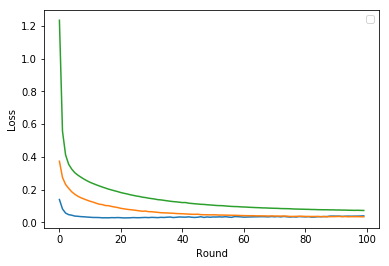

In [67]:
plot_loss([default_manager, fed_constant_n_manager, fed_stk_mgr])

In [42]:
fed_stk6_mgr = federated.FederatedManager(
    [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in fm.make_stacked_dsets(train_dset, p=0.6)],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk6_mgr, num_rounds)

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 1.9042	acc: 47.19%
	wrkr 1		loss: 1.8034	acc: 51.82%
	wrkr 2		loss: 1.8971	acc: 33.33%
	wrkr 3		loss: 1.9010	acc: 39.72%
	wrkr 4		loss: 1.8628	acc: 40.90%
	wrkr 5		loss: 1.9952	acc: 27.78%
	wrkr 6		loss: 1.8331	acc: 47.19%
	wrkr 7		loss: 1.7921	acc: 45.01%
	wrkr 8		loss: 1.9683	acc: 30.53%
	wrkr 9		loss: 1.9748	acc: 35.50%
	combined	loss: 1.7531	acc: 75.30%

Round 1
	wrkr 0		loss: 1.0015	acc: 77.47%
	wrkr 1		loss: 0.9766	acc: 79.64%
	wrkr 2		loss: 1.0431	acc: 72.86%
	wrkr 3		loss: 0.9943	acc: 73.74%
	wrkr 4		loss: 1.0116	acc: 73.08%
	wrkr 5		loss: 0.9972	acc: 69.84%
	wrkr 6		loss: 0.9520	acc: 78.16%
	wrkr 7		loss: 0.9793	acc: 74.67%
	wrkr 8		loss: 1.1017	acc: 65.67%
	wrkr 9		loss: 1.1002	acc: 65.40%
	combined	loss: 0.8611	acc: 84.49%

Round 2
	wrkr 0		loss: 0.6555	acc: 83.17%
	wrkr 1		loss: 0.6206	acc: 83.79%
	wrkr 2		loss: 0.7423	acc: 78.52%
	wrkr 3		loss: 0.6281	acc: 82.64%
	wrkr 4		loss: 0.6314	acc: 80.53%
	wrkr 5		loss: 0.7113	acc: 77.04%
	wrkr 6		loss: 0.598

	wrkr 4		loss: 0.2494	acc: 92.09%
	wrkr 5		loss: 0.2844	acc: 91.08%
	wrkr 6		loss: 0.2315	acc: 93.18%
	wrkr 7		loss: 0.2341	acc: 92.90%
	wrkr 8		loss: 0.2848	acc: 91.03%
	wrkr 9		loss: 0.2634	acc: 91.67%
	combined	loss: 0.2066	acc: 93.80%

Round 22
	wrkr 0		loss: 0.2566	acc: 92.48%
	wrkr 1		loss: 0.2231	acc: 93.14%
	wrkr 2		loss: 0.2422	acc: 93.12%
	wrkr 3		loss: 0.2871	acc: 91.32%
	wrkr 4		loss: 0.2219	acc: 93.25%
	wrkr 5		loss: 0.2447	acc: 92.43%
	wrkr 6		loss: 0.2296	acc: 93.21%
	wrkr 7		loss: 0.2721	acc: 91.48%
	wrkr 8		loss: 0.2722	acc: 91.75%
	wrkr 9		loss: 0.2483	acc: 92.21%
	combined	loss: 0.2027	acc: 93.92%

Round 23
	wrkr 0		loss: 0.2351	acc: 93.00%
	wrkr 1		loss: 0.2220	acc: 93.12%
	wrkr 2		loss: 0.2282	acc: 93.25%
	wrkr 3		loss: 0.2882	acc: 91.13%
	wrkr 4		loss: 0.2418	acc: 92.48%
	wrkr 5		loss: 0.2319	acc: 92.97%
	wrkr 6		loss: 0.2306	acc: 93.18%
	wrkr 7		loss: 0.2277	acc: 93.10%
	wrkr 8		loss: 0.2592	acc: 91.98%
	wrkr 9		loss: 0.2606	acc: 91.70%
	combined	loss: 0.1985	acc

	wrkr 8		loss: 0.2063	acc: 93.46%
	wrkr 9		loss: 0.1740	acc: 94.46%
	combined	loss: 0.1410	acc: 95.67%

Round 43
	wrkr 0		loss: 0.1664	acc: 94.94%
	wrkr 1		loss: 0.1593	acc: 95.04%
	wrkr 2		loss: 0.1722	acc: 94.66%
	wrkr 3		loss: 0.1729	acc: 94.55%
	wrkr 4		loss: 0.1722	acc: 94.55%
	wrkr 5		loss: 0.1886	acc: 93.96%
	wrkr 6		loss: 0.1574	acc: 95.29%
	wrkr 7		loss: 0.1807	acc: 94.27%
	wrkr 8		loss: 0.1775	acc: 94.57%
	wrkr 9		loss: 0.1697	acc: 94.62%
	combined	loss: 0.1394	acc: 95.76%

Round 44
	wrkr 0		loss: 0.1681	acc: 94.98%
	wrkr 1		loss: 0.1598	acc: 95.11%
	wrkr 2		loss: 0.1827	acc: 94.36%
	wrkr 3		loss: 0.1703	acc: 94.77%
	wrkr 4		loss: 0.1761	acc: 94.37%
	wrkr 5		loss: 0.1683	acc: 94.81%
	wrkr 6		loss: 0.1491	acc: 95.55%
	wrkr 7		loss: 0.1612	acc: 94.82%
	wrkr 8		loss: 0.1888	acc: 94.08%
	wrkr 9		loss: 0.1930	acc: 93.73%
	combined	loss: 0.1371	acc: 95.88%

Round 45
	wrkr 0		loss: 0.1604	acc: 95.26%
	wrkr 1		loss: 0.1545	acc: 95.34%
	wrkr 2		loss: 0.1631	acc: 94.90%
	wrkr 3		loss: 

	wrkr 0		loss: 0.1261	acc: 96.18%
	wrkr 1		loss: 0.1258	acc: 96.07%
	wrkr 2		loss: 0.1320	acc: 95.77%
	wrkr 3		loss: 0.1334	acc: 95.76%
	wrkr 4		loss: 0.1336	acc: 95.87%
	wrkr 5		loss: 0.1373	acc: 95.61%
	wrkr 6		loss: 0.1302	acc: 96.04%
	wrkr 7		loss: 0.1317	acc: 96.01%
	wrkr 8		loss: 0.1298	acc: 96.01%
	wrkr 9		loss: 0.1564	acc: 94.91%
	combined	loss: 0.1084	acc: 96.63%

Round 65
	wrkr 0		loss: 0.1341	acc: 95.75%
	wrkr 1		loss: 0.1209	acc: 96.30%
	wrkr 2		loss: 0.1369	acc: 95.67%
	wrkr 3		loss: 0.1366	acc: 95.71%
	wrkr 4		loss: 0.1289	acc: 95.89%
	wrkr 5		loss: 0.1334	acc: 95.69%
	wrkr 6		loss: 0.1220	acc: 96.35%
	wrkr 7		loss: 0.1649	acc: 94.98%
	wrkr 8		loss: 0.1516	acc: 95.27%
	wrkr 9		loss: 0.1648	acc: 94.62%
	combined	loss: 0.1072	acc: 96.69%

Round 66
	wrkr 0		loss: 0.1253	acc: 96.10%
	wrkr 1		loss: 0.1305	acc: 96.02%
	wrkr 2		loss: 0.1326	acc: 95.80%
	wrkr 3		loss: 0.1497	acc: 95.30%
	wrkr 4		loss: 0.1219	acc: 96.14%
	wrkr 5		loss: 0.1458	acc: 95.31%
	wrkr 6		loss: 0.1278	acc:

	wrkr 4		loss: 0.1023	acc: 96.82%
	wrkr 5		loss: 0.1146	acc: 96.33%
	wrkr 6		loss: 0.1059	acc: 96.92%
	wrkr 7		loss: 0.1216	acc: 96.22%
	wrkr 8		loss: 0.1241	acc: 96.09%
	wrkr 9		loss: 0.1192	acc: 96.19%
	combined	loss: 0.0916	acc: 97.12%

Round 86
	wrkr 0		loss: 0.1113	acc: 96.59%
	wrkr 1		loss: 0.1137	acc: 96.49%
	wrkr 2		loss: 0.1224	acc: 96.15%
	wrkr 3		loss: 0.1367	acc: 95.56%
	wrkr 4		loss: 0.1092	acc: 96.60%
	wrkr 5		loss: 0.1213	acc: 96.13%
	wrkr 6		loss: 0.1107	acc: 96.64%
	wrkr 7		loss: 0.1074	acc: 96.72%
	wrkr 8		loss: 0.1250	acc: 96.03%
	wrkr 9		loss: 0.1232	acc: 95.96%
	combined	loss: 0.0917	acc: 97.17%

Round 87
	wrkr 0		loss: 0.1074	acc: 96.65%
	wrkr 1		loss: 0.1089	acc: 96.59%
	wrkr 2		loss: 0.1108	acc: 96.51%
	wrkr 3		loss: 0.1343	acc: 95.68%
	wrkr 4		loss: 0.1146	acc: 96.42%
	wrkr 5		loss: 0.1197	acc: 96.04%
	wrkr 6		loss: 0.1114	acc: 96.63%
	wrkr 7		loss: 0.1075	acc: 96.79%
	wrkr 8		loss: 0.1193	acc: 96.37%
	wrkr 9		loss: 0.1139	acc: 96.33%
	combined	loss: 0.0912	acc

In [43]:
fed_stk8_mgr = federated.FederatedManager(
    [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in fm.make_stacked_dsets(train_dset, p=0.8)],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk8_mgr, num_rounds)

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 2.1946	acc: 29.16%
	wrkr 1		loss: 2.0555	acc: 36.04%
	wrkr 2		loss: 2.2982	acc: 10.97%
	wrkr 3		loss: 2.4295	acc: 12.83%
	wrkr 4		loss: 2.3052	acc: 18.46%
	wrkr 5		loss: 2.5215	acc: 9.00%
	wrkr 6		loss: 2.2290	acc: 19.78%
	wrkr 7		loss: 2.1667	acc: 23.64%
	wrkr 8		loss: 2.5796	acc: 9.74%
	wrkr 9		loss: 2.5145	acc: 11.01%
	combined	loss: 1.9944	acc: 71.64%

Round 1
	wrkr 0		loss: 1.6812	acc: 55.81%
	wrkr 1		loss: 1.6162	acc: 60.40%
	wrkr 2		loss: 1.7615	acc: 32.84%
	wrkr 3		loss: 1.8789	acc: 36.63%
	wrkr 4		loss: 1.7781	acc: 48.55%
	wrkr 5		loss: 1.9291	acc: 33.17%
	wrkr 6		loss: 1.6679	acc: 53.65%
	wrkr 7		loss: 1.7005	acc: 44.05%
	wrkr 8		loss: 2.0414	acc: 25.08%
	wrkr 9		loss: 1.8582	acc: 44.26%
	combined	loss: 1.4470	acc: 78.70%

Round 2
	wrkr 0		loss: 1.0954	acc: 72.87%
	wrkr 1		loss: 1.1154	acc: 73.35%
	wrkr 2		loss: 1.1450	acc: 65.86%
	wrkr 3		loss: 1.3032	acc: 58.20%
	wrkr 4		loss: 1.1781	acc: 66.28%
	wrkr 5		loss: 1.3180	acc: 53.14%
	wrkr 6		loss: 1.1223	

	wrkr 4		loss: 0.3797	acc: 87.13%
	wrkr 5		loss: 0.4206	acc: 86.06%
	wrkr 6		loss: 0.3107	acc: 90.82%
	wrkr 7		loss: 0.3424	acc: 89.41%
	wrkr 8		loss: 0.3727	acc: 88.46%
	wrkr 9		loss: 0.4728	acc: 83.63%
	combined	loss: 0.2533	acc: 92.63%

Round 22
	wrkr 0		loss: 0.3094	acc: 91.08%
	wrkr 1		loss: 0.3179	acc: 90.07%
	wrkr 2		loss: 0.3658	acc: 88.97%
	wrkr 3		loss: 0.4267	acc: 86.09%
	wrkr 4		loss: 0.3388	acc: 88.74%
	wrkr 5		loss: 0.3667	acc: 88.37%
	wrkr 6		loss: 0.3214	acc: 90.30%
	wrkr 7		loss: 0.3607	acc: 88.48%
	wrkr 8		loss: 0.3757	acc: 88.34%
	wrkr 9		loss: 0.4262	acc: 85.43%
	combined	loss: 0.2495	acc: 92.77%

Round 23
	wrkr 0		loss: 0.3216	acc: 90.61%
	wrkr 1		loss: 0.2975	acc: 90.98%
	wrkr 2		loss: 0.3279	acc: 90.30%
	wrkr 3		loss: 0.3635	acc: 88.76%
	wrkr 4		loss: 0.3431	acc: 88.62%
	wrkr 5		loss: 0.3809	acc: 87.42%
	wrkr 6		loss: 0.3146	acc: 90.59%
	wrkr 7		loss: 0.3705	acc: 88.23%
	wrkr 8		loss: 0.4301	acc: 86.37%
	wrkr 9		loss: 0.3675	acc: 87.54%
	combined	loss: 0.2449	acc

	wrkr 8		loss: 0.2874	acc: 91.08%
	wrkr 9		loss: 0.2957	acc: 90.11%
	combined	loss: 0.1850	acc: 94.44%

Round 43
	wrkr 0		loss: 0.2291	acc: 93.29%
	wrkr 1		loss: 0.2360	acc: 92.41%
	wrkr 2		loss: 0.2636	acc: 92.09%
	wrkr 3		loss: 0.3397	acc: 88.85%
	wrkr 4		loss: 0.2754	acc: 90.69%
	wrkr 5		loss: 0.2973	acc: 90.31%
	wrkr 6		loss: 0.2459	acc: 92.36%
	wrkr 7		loss: 0.2819	acc: 90.90%
	wrkr 8		loss: 0.2891	acc: 91.20%
	wrkr 9		loss: 0.2889	acc: 90.14%
	combined	loss: 0.1826	acc: 94.47%

Round 44
	wrkr 0		loss: 0.2579	acc: 92.60%
	wrkr 1		loss: 0.2337	acc: 92.64%
	wrkr 2		loss: 0.2754	acc: 91.75%
	wrkr 3		loss: 0.2769	acc: 91.39%
	wrkr 4		loss: 0.2935	acc: 89.79%
	wrkr 5		loss: 0.2776	acc: 91.14%
	wrkr 6		loss: 0.2238	acc: 93.12%
	wrkr 7		loss: 0.2508	acc: 92.05%
	wrkr 8		loss: 0.3090	acc: 90.30%
	wrkr 9		loss: 0.2779	acc: 90.47%
	combined	loss: 0.1805	acc: 94.60%

Round 45
	wrkr 0		loss: 0.2194	acc: 93.73%
	wrkr 1		loss: 0.2265	acc: 92.96%
	wrkr 2		loss: 0.2745	acc: 91.54%
	wrkr 3		loss: 

	wrkr 0		loss: 0.1854	acc: 94.55%
	wrkr 1		loss: 0.2080	acc: 93.19%
	wrkr 2		loss: 0.2082	acc: 93.53%
	wrkr 3		loss: 0.2547	acc: 91.90%
	wrkr 4		loss: 0.2118	acc: 92.97%
	wrkr 5		loss: 0.2031	acc: 93.45%
	wrkr 6		loss: 0.2084	acc: 93.53%
	wrkr 7		loss: 0.2132	acc: 93.08%
	wrkr 8		loss: 0.2328	acc: 92.76%
	wrkr 9		loss: 0.2283	acc: 92.40%
	combined	loss: 0.1447	acc: 95.65%

Round 65
	wrkr 0		loss: 0.1984	acc: 94.20%
	wrkr 1		loss: 0.1923	acc: 94.00%
	wrkr 2		loss: 0.2027	acc: 93.76%
	wrkr 3		loss: 0.2793	acc: 90.83%
	wrkr 4		loss: 0.1959	acc: 93.61%
	wrkr 5		loss: 0.2341	acc: 92.38%
	wrkr 6		loss: 0.1947	acc: 94.00%
	wrkr 7		loss: 0.1953	acc: 93.71%
	wrkr 8		loss: 0.2558	acc: 92.01%
	wrkr 9		loss: 0.2348	acc: 92.09%
	combined	loss: 0.1437	acc: 95.70%

Round 66
	wrkr 0		loss: 0.1927	acc: 94.35%
	wrkr 1		loss: 0.1739	acc: 94.69%
	wrkr 2		loss: 0.2023	acc: 93.71%
	wrkr 3		loss: 0.2462	acc: 92.27%
	wrkr 4		loss: 0.2263	acc: 92.40%
	wrkr 5		loss: 0.2171	acc: 92.96%
	wrkr 6		loss: 0.1962	acc:

	wrkr 4		loss: 0.1938	acc: 93.43%
	wrkr 5		loss: 0.1959	acc: 93.57%
	wrkr 6		loss: 0.1808	acc: 94.46%
	wrkr 7		loss: 0.1815	acc: 94.30%
	wrkr 8		loss: 0.1902	acc: 93.99%
	wrkr 9		loss: 0.2291	acc: 92.06%
	combined	loss: 0.1227	acc: 96.18%

Round 86
	wrkr 0		loss: 0.1603	acc: 95.35%
	wrkr 1		loss: 0.1710	acc: 94.59%
	wrkr 2		loss: 0.1547	acc: 95.36%
	wrkr 3		loss: 0.2148	acc: 92.89%
	wrkr 4		loss: 0.1975	acc: 93.31%
	wrkr 5		loss: 0.2045	acc: 93.20%
	wrkr 6		loss: 0.1699	acc: 94.83%
	wrkr 7		loss: 0.1713	acc: 94.48%
	wrkr 8		loss: 0.1711	acc: 94.77%
	wrkr 9		loss: 0.1983	acc: 93.50%
	combined	loss: 0.1217	acc: 96.23%

Round 87
	wrkr 0		loss: 0.1545	acc: 95.39%
	wrkr 1		loss: 0.1664	acc: 94.69%
	wrkr 2		loss: 0.1710	acc: 94.87%
	wrkr 3		loss: 0.2083	acc: 93.22%
	wrkr 4		loss: 0.1929	acc: 93.58%
	wrkr 5		loss: 0.1917	acc: 93.75%
	wrkr 6		loss: 0.1659	acc: 94.91%
	wrkr 7		loss: 0.2098	acc: 93.32%
	wrkr 8		loss: 0.2134	acc: 93.28%
	wrkr 9		loss: 0.2292	acc: 92.24%
	combined	loss: 0.1210	acc

No handles with labels found to put in legend.


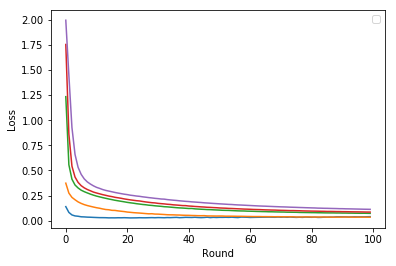

In [68]:
plot_loss([default_manager, fed_constant_n_manager, fed_stk_mgr, fed_stk6_mgr, fed_stk8_mgr])

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f69790ecac8>,
       dtype=object))

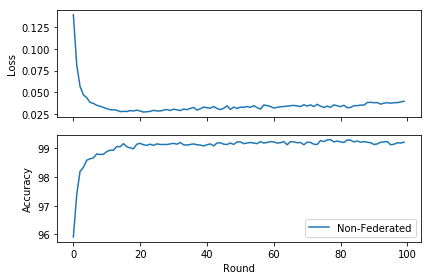

In [69]:
fm.plot(default_manager, label='Non-Federated')

In [54]:
fed_stk10_mgr = federated.FederatedManager(
    [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in fm.make_stacked_dsets(train_dset, p=1)],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk10_mgr, num_rounds)

Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 5.1364	acc: 9.80%
	wrkr 1		loss: 5.1769	acc: 11.35%
	wrkr 2		loss: 6.7080	acc: 10.32%
	wrkr 3		loss: 6.5769	acc: 10.10%
	wrkr 4		loss: 6.5949	acc: 9.82%
	wrkr 5		loss: 7.6801	acc: 8.92%
	wrkr 6		loss: 6.0370	acc: 9.58%
	wrkr 7		loss: 6.2687	acc: 10.28%
	wrkr 8		loss: 6.5418	acc: 9.74%
	wrkr 9		loss: 6.7862	acc: 10.09%
	combined	loss: 2.2209	acc: 22.43%

Round 1
	wrkr 0		loss: 5.9347	acc: 9.80%
	wrkr 1		loss: 6.2278	acc: 11.35%
	wrkr 2		loss: 7.3443	acc: 10.32%
	wrkr 3		loss: 7.1073	acc: 10.10%
	wrkr 4		loss: 7.2855	acc: 9.82%
	wrkr 5		loss: 8.2861	acc: 8.92%
	wrkr 6		loss: 6.8148	acc: 9.58%
	wrkr 7		loss: 7.1076	acc: 10.28%
	wrkr 8		loss: 6.8188	acc: 9.74%
	wrkr 9		loss: 7.2719	acc: 10.09%
	combined	loss: 2.1270	acc: 35.95%

Round 2
	wrkr 0		loss: 6.6015	acc: 9.80%
	wrkr 1		loss: 7.1055	acc: 11.35%
	wrkr 2		loss: 7.7485	acc: 10.32%
	wrkr 3		loss: 7.4762	acc: 10.10%
	wrkr 4		loss: 7.7916	acc: 9.82%
	wrkr 5		loss: 8.6813	acc: 8.92%
	wrkr 6		loss: 7.3109	acc: 9.58%


	wrkr 6		loss: 9.3032	acc: 9.58%
	wrkr 7		loss: 8.7112	acc: 10.28%
	wrkr 8		loss: 12.2254	acc: 9.74%
	wrkr 9		loss: 10.4261	acc: 10.09%
	combined	loss: 1.3558	acc: 75.25%

Round 22
	wrkr 0		loss: 7.5153	acc: 9.80%
	wrkr 1		loss: 6.3495	acc: 11.36%
	wrkr 2		loss: 10.1608	acc: 10.32%
	wrkr 3		loss: 10.2867	acc: 10.10%
	wrkr 4		loss: 10.2901	acc: 9.82%
	wrkr 5		loss: 11.4905	acc: 8.92%
	wrkr 6		loss: 9.6230	acc: 9.58%
	wrkr 7		loss: 8.9034	acc: 10.28%
	wrkr 8		loss: 11.8661	acc: 9.74%
	wrkr 9		loss: 11.1288	acc: 10.09%
	combined	loss: 1.3307	acc: 75.71%

Round 23
	wrkr 0		loss: 7.4413	acc: 9.80%
	wrkr 1		loss: 6.1894	acc: 11.39%
	wrkr 2		loss: 10.2641	acc: 10.32%
	wrkr 3		loss: 10.2071	acc: 10.10%
	wrkr 4		loss: 10.1459	acc: 9.82%
	wrkr 5		loss: 11.0172	acc: 8.92%
	wrkr 6		loss: 9.3548	acc: 9.58%
	wrkr 7		loss: 9.1044	acc: 10.28%
	wrkr 8		loss: 12.4649	acc: 9.74%
	wrkr 9		loss: 10.7278	acc: 10.09%
	combined	loss: 1.3058	acc: 75.66%

Round 24
	wrkr 0		loss: 7.2897	acc: 9.80%
	wrkr 1		loss:

	wrkr 9		loss: 11.3373	acc: 10.09%
	combined	loss: 0.9544	acc: 79.80%

Round 43
	wrkr 0		loss: 5.5495	acc: 15.26%
	wrkr 1		loss: 4.2347	acc: 18.36%
	wrkr 2		loss: 9.6934	acc: 10.32%
	wrkr 3		loss: 11.1063	acc: 10.10%
	wrkr 4		loss: 10.2431	acc: 9.82%
	wrkr 5		loss: 13.0284	acc: 8.92%
	wrkr 6		loss: 8.1210	acc: 9.58%
	wrkr 7		loss: 8.4658	acc: 10.28%
	wrkr 8		loss: 13.4609	acc: 9.74%
	wrkr 9		loss: 11.5826	acc: 10.09%
	combined	loss: 0.9423	acc: 80.50%

Round 44
	wrkr 0		loss: 5.6373	acc: 15.17%
	wrkr 1		loss: 4.1901	acc: 18.57%
	wrkr 2		loss: 9.8761	acc: 10.32%
	wrkr 3		loss: 9.8453	acc: 10.10%
	wrkr 4		loss: 9.8604	acc: 9.82%
	wrkr 5		loss: 13.2529	acc: 8.92%
	wrkr 6		loss: 8.1965	acc: 9.58%
	wrkr 7		loss: 7.6630	acc: 10.28%
	wrkr 8		loss: 14.6632	acc: 9.74%
	wrkr 9		loss: 11.7327	acc: 10.09%
	combined	loss: 0.9300	acc: 80.76%

Round 45
	wrkr 0		loss: 5.5814	acc: 15.31%
	wrkr 1		loss: 4.0821	acc: 18.98%
	wrkr 2		loss: 10.0756	acc: 10.32%
	wrkr 3		loss: 11.0303	acc: 10.10%
	wrkr 4		los

	wrkr 1		loss: 3.2811	acc: 27.29%
	wrkr 2		loss: 9.2317	acc: 10.32%
	wrkr 3		loss: 7.7681	acc: 10.10%
	wrkr 4		loss: 7.8572	acc: 9.82%
	wrkr 5		loss: 11.9743	acc: 8.92%
	wrkr 6		loss: 6.4497	acc: 9.60%
	wrkr 7		loss: 7.2936	acc: 10.34%
	wrkr 8		loss: 19.0871	acc: 9.74%
	wrkr 9		loss: 10.9445	acc: 10.09%
	combined	loss: 0.7682	acc: 79.69%

Round 65
	wrkr 0		loss: 4.5821	acc: 18.74%
	wrkr 1		loss: 3.3298	acc: 27.25%
	wrkr 2		loss: 9.5196	acc: 10.32%
	wrkr 3		loss: 13.2941	acc: 10.10%
	wrkr 4		loss: 9.2658	acc: 9.82%
	wrkr 5		loss: 13.1556	acc: 8.92%
	wrkr 6		loss: 6.8276	acc: 9.58%
	wrkr 7		loss: 6.4564	acc: 10.50%
	wrkr 8		loss: 9.3791	acc: 9.74%
	wrkr 9		loss: 12.0579	acc: 10.09%
	combined	loss: 0.7966	acc: 78.03%

Round 66
	wrkr 0		loss: 4.4223	acc: 19.40%
	wrkr 1		loss: 3.2297	acc: 28.29%
	wrkr 2		loss: 8.6434	acc: 10.32%
	wrkr 3		loss: 7.3031	acc: 10.10%
	wrkr 4		loss: 9.9005	acc: 9.82%
	wrkr 5		loss: 12.6763	acc: 8.92%
	wrkr 6		loss: 6.3273	acc: 9.60%
	wrkr 7		loss: 6.9235	acc: 10.

	wrkr 5		loss: 15.1478	acc: 8.92%
	wrkr 6		loss: 6.1573	acc: 10.19%
	wrkr 7		loss: 5.5255	acc: 11.73%
	wrkr 8		loss: 7.5270	acc: 9.74%
	wrkr 9		loss: 15.6275	acc: 10.09%
	combined	loss: 0.6882	acc: 79.08%

Round 86
	wrkr 0		loss: 3.7996	acc: 21.57%
	wrkr 1		loss: 2.8524	acc: 34.69%
	wrkr 2		loss: 8.9262	acc: 10.32%
	wrkr 3		loss: 8.0234	acc: 10.10%
	wrkr 4		loss: 11.6125	acc: 9.82%
	wrkr 5		loss: 10.3792	acc: 8.92%
	wrkr 6		loss: 5.5972	acc: 11.25%
	wrkr 7		loss: 5.8131	acc: 11.78%
	wrkr 8		loss: 21.2166	acc: 9.74%
	wrkr 9		loss: 7.8018	acc: 10.29%
	combined	loss: 0.6881	acc: 76.57%

Round 87
	wrkr 0		loss: 4.0127	acc: 21.29%
	wrkr 1		loss: 2.8957	acc: 34.10%
	wrkr 2		loss: 8.9015	acc: 10.32%
	wrkr 3		loss: 9.6107	acc: 10.10%
	wrkr 4		loss: 5.9613	acc: 12.01%
	wrkr 5		loss: 15.0116	acc: 8.92%
	wrkr 6		loss: 5.5524	acc: 11.43%
	wrkr 7		loss: 5.5947	acc: 11.94%
	wrkr 8		loss: 7.1103	acc: 9.74%
	wrkr 9		loss: 16.4376	acc: 10.09%
	combined	loss: 0.6902	acc: 78.68%

Round 88
	wrkr 0		loss: 

Distributions
Counter({0: 5923})
Counter({1: 6742})
Counter({2: 5958})
Counter({3: 6131})
Counter({4: 5842})
Counter({5: 5421})
Counter({6: 5918})
Counter({7: 6265})
Counter({8: 5851})
Counter({9: 5949})


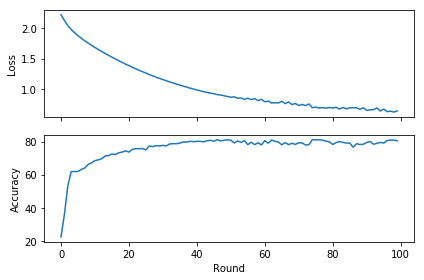

In [56]:
fm.plot(fed_stk10_mgr)
fm.check_dsets(fm.make_stacked_dsets(train_dset, p=1))

In [58]:
stk90_dsets = fm.make_stacked_dsets(train_dset, p=0.9)
fm.check_dsets(stk90_dsets)
fed_stk90_mgr = federated.FederatedManager(
    [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in stk90_dsets],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk90_mgr, num_rounds)

Distributions
Counter({0: 5303, 7: 80, 6: 74, 1: 68, 2: 67, 3: 62, 8: 60, 5: 54, 9: 53, 4: 49})
Counter({1: 6089, 7: 81, 0: 67, 9: 64, 3: 64, 8: 63, 6: 61, 5: 60, 2: 51, 4: 49})
Counter({2: 5356, 7: 86, 9: 73, 5: 70, 3: 69, 0: 69, 1: 69, 8: 57, 6: 55, 4: 54})
Counter({3: 5537, 1: 79, 8: 77, 2: 74, 6: 74, 4: 73, 0: 67, 5: 63, 7: 61, 9: 60})
Counter({4: 5281, 6: 76, 2: 69, 8: 67, 5: 65, 0: 65, 7: 61, 9: 58, 1: 57, 3: 57})
Counter({5: 4845, 8: 75, 1: 75, 6: 72, 0: 70, 2: 69, 9: 68, 4: 65, 3: 56, 7: 55})
Counter({6: 5308, 0: 74, 2: 71, 1: 68, 3: 68, 8: 68, 9: 68, 7: 65, 5: 64, 4: 60})
Counter({7: 5649, 1: 95, 4: 78, 9: 76, 3: 74, 6: 72, 2: 67, 0: 67, 5: 66, 8: 58})
Counter({8: 5242, 3: 77, 1: 72, 4: 71, 9: 69, 2: 66, 0: 65, 5: 63, 7: 62, 6: 58})
Counter({9: 5360, 8: 84, 0: 76, 5: 71, 1: 70, 6: 68, 2: 68, 3: 67, 7: 65, 4: 62})
Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 2.5689	acc: 9.80%
	wrkr 1		loss: 2.3582	acc: 12.05%
	wrkr 2		loss: 2.8177	acc: 10.32%
	wrkr 3		loss: 2.7794	acc: 10.10%
	wrkr 4		loss: 2.7907	acc: 9.82%
	wrkr 5		loss: 3.1328	acc: 8.92%
	wrkr 6		loss: 2.6299	acc: 9.58%
	wrkr 7		loss: 2.6453	acc: 10.29%
	wrkr 8		loss: 3.1858	acc: 9.74%
	wrkr 9		loss: 2.9605	acc: 10.10%
	combined	loss: 2.1409	acc: 55.02%

Round 1
	wrkr 0		loss: 2.3027	acc: 16.92%
	wrkr 1		loss: 2.1037	acc: 31.11%
	wrkr 2		loss: 2.5047	acc: 10.40%
	wrkr 3		loss: 2.5002	acc: 10.67%
	wrkr 4		loss: 2.4776	acc: 15.85%
	wrkr 5		loss: 2.7701	acc: 8.92%
	wrkr 6		loss: 2.3642	acc: 12.23%
	wrkr 7		loss: 2.2905	acc: 19.13%
	wrkr 8		loss: 2.7256	acc: 9.74%
	wrkr 9		loss: 2.7453	acc: 13.87%
	combined	loss: 1.8584	acc: 73.05%

Round 2
	wrkr 0		loss: 1.9431	acc: 38.69%
	wrkr 1		loss: 1.8024	acc: 44.63%
	wrkr 2		loss: 2.1009	acc: 20.62%
	wrkr 3		loss: 2.1415	acc: 21.04%
	wrkr 4		loss: 2.1306	acc: 34.16%
	wrkr 5		loss: 2.3438	acc: 13.08%
	wrkr 6		loss: 1.9249	acc: 

	wrkr 4		loss: 0.5532	acc: 80.92%
	wrkr 5		loss: 0.5621	acc: 80.38%
	wrkr 6		loss: 0.4338	acc: 86.63%
	wrkr 7		loss: 0.4873	acc: 84.35%
	wrkr 8		loss: 0.6455	acc: 78.26%
	wrkr 9		loss: 0.5585	acc: 80.11%
	combined	loss: 0.3053	acc: 91.34%

Round 22
	wrkr 0		loss: 0.4082	acc: 87.89%
	wrkr 1		loss: 0.4317	acc: 86.39%
	wrkr 2		loss: 0.6577	acc: 78.03%
	wrkr 3		loss: 0.6648	acc: 77.50%
	wrkr 4		loss: 0.5514	acc: 81.24%
	wrkr 5		loss: 0.5507	acc: 81.12%
	wrkr 6		loss: 0.4254	acc: 87.07%
	wrkr 7		loss: 0.5343	acc: 82.09%
	wrkr 8		loss: 0.4944	acc: 84.10%
	wrkr 9		loss: 0.5477	acc: 80.76%
	combined	loss: 0.3001	acc: 91.55%

Round 23
	wrkr 0		loss: 0.4861	acc: 85.12%
	wrkr 1		loss: 0.4387	acc: 86.20%
	wrkr 2		loss: 0.6312	acc: 78.54%
	wrkr 3		loss: 0.5582	acc: 81.47%
	wrkr 4		loss: 0.4578	acc: 84.31%
	wrkr 5		loss: 0.5477	acc: 81.04%
	wrkr 6		loss: 0.4281	acc: 86.99%
	wrkr 7		loss: 0.4239	acc: 86.76%
	wrkr 8		loss: 0.6072	acc: 79.42%
	wrkr 9		loss: 0.7090	acc: 74.79%
	combined	loss: 0.2955	acc

	wrkr 8		loss: 0.3836	acc: 87.91%
	wrkr 9		loss: 0.4439	acc: 84.59%
	combined	loss: 0.2346	acc: 93.10%

Round 43
	wrkr 0		loss: 0.3231	acc: 90.47%
	wrkr 1		loss: 0.3286	acc: 89.46%
	wrkr 2		loss: 0.3891	acc: 87.94%
	wrkr 3		loss: 0.5582	acc: 81.52%
	wrkr 4		loss: 0.4613	acc: 84.32%
	wrkr 5		loss: 0.4180	acc: 85.93%
	wrkr 6		loss: 0.3394	acc: 89.74%
	wrkr 7		loss: 0.3886	acc: 87.32%
	wrkr 8		loss: 0.4356	acc: 86.06%
	wrkr 9		loss: 0.4807	acc: 83.29%
	combined	loss: 0.2324	acc: 93.14%

Round 44
	wrkr 0		loss: 0.3464	acc: 89.69%
	wrkr 1		loss: 0.3184	acc: 89.68%
	wrkr 2		loss: 0.4909	acc: 84.03%
	wrkr 3		loss: 0.5310	acc: 81.90%
	wrkr 4		loss: 0.4253	acc: 85.57%
	wrkr 5		loss: 0.3651	acc: 87.95%
	wrkr 6		loss: 0.3016	acc: 90.81%
	wrkr 7		loss: 0.4318	acc: 85.59%
	wrkr 8		loss: 0.5052	acc: 83.44%
	wrkr 9		loss: 0.4449	acc: 84.38%
	combined	loss: 0.2302	acc: 93.24%

Round 45
	wrkr 0		loss: 0.3612	acc: 89.09%
	wrkr 1		loss: 0.3307	acc: 89.43%
	wrkr 2		loss: 0.4053	acc: 87.46%
	wrkr 3		loss: 

	wrkr 0		loss: 0.2832	acc: 91.47%
	wrkr 1		loss: 0.3250	acc: 89.51%
	wrkr 2		loss: 0.3957	acc: 87.41%
	wrkr 3		loss: 0.4134	acc: 86.02%
	wrkr 4		loss: 0.3372	acc: 88.50%
	wrkr 5		loss: 0.3333	acc: 89.04%
	wrkr 6		loss: 0.2701	acc: 91.78%
	wrkr 7		loss: 0.3215	acc: 89.61%
	wrkr 8		loss: 0.3168	acc: 89.78%
	wrkr 9		loss: 0.4393	acc: 84.77%
	combined	loss: 0.1912	acc: 94.26%

Round 65
	wrkr 0		loss: 0.3029	acc: 91.00%
	wrkr 1		loss: 0.3058	acc: 90.15%
	wrkr 2		loss: 0.3402	acc: 89.03%
	wrkr 3		loss: 0.4276	acc: 85.61%
	wrkr 4		loss: 0.3630	acc: 87.65%
	wrkr 5		loss: 0.3128	acc: 89.72%
	wrkr 6		loss: 0.2761	acc: 91.38%
	wrkr 7		loss: 0.3533	acc: 88.51%
	wrkr 8		loss: 0.3914	acc: 87.45%
	wrkr 9		loss: 0.4105	acc: 85.76%
	combined	loss: 0.1895	acc: 94.28%

Round 66
	wrkr 0		loss: 0.3112	acc: 90.66%
	wrkr 1		loss: 0.3185	acc: 89.74%
	wrkr 2		loss: 0.3917	acc: 87.57%
	wrkr 3		loss: 0.4605	acc: 84.22%
	wrkr 4		loss: 0.3807	acc: 87.07%
	wrkr 5		loss: 0.3650	acc: 87.66%
	wrkr 6		loss: 0.3171	acc:

	wrkr 4		loss: 0.2601	acc: 91.28%
	wrkr 5		loss: 0.2627	acc: 91.37%
	wrkr 6		loss: 0.2366	acc: 92.78%
	wrkr 7		loss: 0.3229	acc: 89.57%
	wrkr 8		loss: 0.3537	acc: 88.36%
	wrkr 9		loss: 0.3106	acc: 89.05%
	combined	loss: 0.1642	acc: 95.04%

Round 86
	wrkr 0		loss: 0.2680	acc: 92.03%
	wrkr 1		loss: 0.2291	acc: 92.57%
	wrkr 2		loss: 0.3317	acc: 89.52%
	wrkr 3		loss: 0.3995	acc: 86.68%
	wrkr 4		loss: 0.2984	acc: 89.62%
	wrkr 5		loss: 0.3461	acc: 88.43%
	wrkr 6		loss: 0.2364	acc: 92.87%
	wrkr 7		loss: 0.2769	acc: 91.03%
	wrkr 8		loss: 0.3863	acc: 87.38%
	wrkr 9		loss: 0.3531	acc: 87.44%
	combined	loss: 0.1627	acc: 95.15%

Round 87
	wrkr 0		loss: 0.2513	acc: 92.55%
	wrkr 1		loss: 0.2522	acc: 91.96%
	wrkr 2		loss: 0.3842	acc: 87.72%
	wrkr 3		loss: 0.3828	acc: 87.16%
	wrkr 4		loss: 0.3247	acc: 88.83%
	wrkr 5		loss: 0.2973	acc: 90.28%
	wrkr 6		loss: 0.2529	acc: 92.37%
	wrkr 7		loss: 0.3021	acc: 90.15%
	wrkr 8		loss: 0.3526	acc: 88.34%
	wrkr 9		loss: 0.3118	acc: 89.11%
	combined	loss: 0.1621	acc

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f69798c0c88>,
       dtype=object))

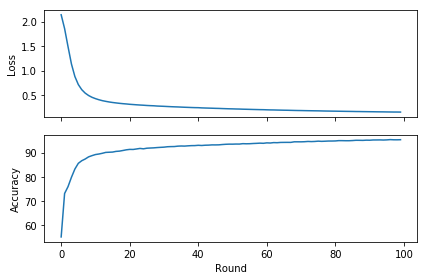

In [59]:
fm.plot(fed_stk90_mgr)

In [60]:
stk95_dsets = fm.make_stacked_dsets(train_dset, p=0.95)
fm.check_dsets(stk95_dsets)
fed_stk95_mgr = federated.FederatedManager(
    [DataLoader(dset, batch_size=train_batch_size, shuffle=True)
                        for dset in stk95_dsets],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_stk95_mgr, num_rounds)

Distributions
Counter({0: 5607, 3: 37, 8: 36, 2: 35, 4: 33, 7: 33, 5: 32, 1: 32, 6: 31, 9: 30})
Counter({1: 6408, 6: 41, 8: 38, 4: 37, 3: 36, 7: 35, 9: 32, 5: 32, 0: 29, 2: 29})
Counter({2: 5647, 0: 44, 1: 38, 5: 37, 9: 37, 4: 37, 6: 36, 3: 35, 7: 34, 8: 26})
Counter({3: 5827, 1: 44, 2: 39, 9: 38, 0: 34, 7: 34, 4: 33, 6: 24, 8: 22, 5: 21})
Counter({4: 5525, 5: 41, 8: 41, 9: 38, 2: 37, 0: 37, 1: 33, 6: 28, 3: 25, 7: 22})
Counter({5: 5132, 7: 46, 0: 43, 8: 38, 3: 36, 2: 35, 1: 34, 9: 33, 6: 26, 4: 24})
Counter({6: 5637, 7: 46, 5: 45, 1: 38, 8: 34, 3: 34, 9: 29, 2: 29, 4: 29, 0: 25})
Counter({7: 5951, 0: 41, 4: 41, 1: 39, 8: 37, 5: 36, 3: 32, 6: 30, 2: 28, 9: 20})
Counter({8: 5544, 2: 41, 1: 41, 4: 41, 3: 36, 9: 33, 6: 32, 0: 30, 7: 28, 5: 26})
Counter({9: 5659, 4: 42, 2: 38, 7: 36, 8: 35, 1: 35, 6: 33, 3: 33, 0: 33, 5: 19})
Training 100 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Round 0
	wrkr 0		loss: 2.9328	acc: 9.80%
	wrkr 1		loss: 2.5903	acc: 11.87%
	wrkr 2		loss: 3.4343	acc: 10.32%
	wrkr 3		loss: 3.4424	acc: 10.10%
	wrkr 4		loss: 3.3756	acc: 9.82%
	wrkr 5		loss: 4.0274	acc: 8.92%
	wrkr 6		loss: 3.1296	acc: 9.58%
	wrkr 7		loss: 3.0484	acc: 10.28%
	wrkr 8		loss: 3.6366	acc: 9.74%
	wrkr 9		loss: 3.5435	acc: 10.09%
	combined	loss: 2.1498	acc: 47.59%

Round 1
	wrkr 0		loss: 2.7949	acc: 9.80%
	wrkr 1		loss: 2.3830	acc: 21.17%
	wrkr 2		loss: 3.1755	acc: 10.32%
	wrkr 3		loss: 3.2645	acc: 10.10%
	wrkr 4		loss: 3.0543	acc: 9.82%
	wrkr 5		loss: 3.5729	acc: 8.92%
	wrkr 6		loss: 2.9460	acc: 9.58%
	wrkr 7		loss: 2.8171	acc: 10.48%
	wrkr 8		loss: 3.4710	acc: 9.74%
	wrkr 9		loss: 3.1925	acc: 10.09%
	combined	loss: 1.9543	acc: 69.14%

Round 2
	wrkr 0		loss: 2.4877	acc: 18.80%
	wrkr 1		loss: 2.1477	acc: 32.48%
	wrkr 2		loss: 3.0770	acc: 10.32%
	wrkr 3		loss: 2.9457	acc: 10.10%
	wrkr 4		loss: 2.8892	acc: 10.85%
	wrkr 5		loss: 3.4962	acc: 8.92%
	wrkr 6		loss: 2.6080	acc: 12.4

	wrkr 4		loss: 0.7755	acc: 73.60%
	wrkr 5		loss: 0.8981	acc: 67.73%
	wrkr 6		loss: 0.5911	acc: 81.56%
	wrkr 7		loss: 0.8066	acc: 73.62%
	wrkr 8		loss: 0.9685	acc: 65.64%
	wrkr 9		loss: 0.9451	acc: 64.90%
	combined	loss: 0.3866	acc: 89.35%

Round 22
	wrkr 0		loss: 0.5078	acc: 85.11%
	wrkr 1		loss: 0.5741	acc: 82.55%
	wrkr 2		loss: 0.8739	acc: 69.84%
	wrkr 3		loss: 1.0421	acc: 65.10%
	wrkr 4		loss: 0.7798	acc: 74.05%
	wrkr 5		loss: 0.9299	acc: 66.26%
	wrkr 6		loss: 0.5877	acc: 81.72%
	wrkr 7		loss: 0.7179	acc: 75.57%
	wrkr 8		loss: 0.9047	acc: 68.35%
	wrkr 9		loss: 0.9424	acc: 65.21%
	combined	loss: 0.3779	acc: 89.72%

Round 23
	wrkr 0		loss: 0.5045	acc: 85.02%
	wrkr 1		loss: 0.6402	acc: 80.72%
	wrkr 2		loss: 0.7399	acc: 75.64%
	wrkr 3		loss: 0.9462	acc: 68.48%
	wrkr 4		loss: 0.7647	acc: 74.65%
	wrkr 5		loss: 0.9609	acc: 66.15%
	wrkr 6		loss: 0.6296	acc: 80.38%
	wrkr 7		loss: 0.7169	acc: 75.83%
	wrkr 8		loss: 0.8991	acc: 68.73%
	wrkr 9		loss: 1.1395	acc: 60.68%
	combined	loss: 0.3714	acc

	wrkr 8		loss: 0.7149	acc: 75.34%
	wrkr 9		loss: 0.8935	acc: 68.73%
	combined	loss: 0.2930	acc: 91.45%

Round 43
	wrkr 0		loss: 0.4487	acc: 86.34%
	wrkr 1		loss: 0.4461	acc: 86.08%
	wrkr 2		loss: 0.6547	acc: 78.36%
	wrkr 3		loss: 0.7686	acc: 74.39%
	wrkr 4		loss: 0.5916	acc: 80.08%
	wrkr 5		loss: 0.6001	acc: 79.25%
	wrkr 6		loss: 0.5103	acc: 84.61%
	wrkr 7		loss: 0.6750	acc: 76.82%
	wrkr 8		loss: 0.7916	acc: 72.90%
	wrkr 9		loss: 0.6831	acc: 75.81%
	combined	loss: 0.2906	acc: 91.45%

Round 44
	wrkr 0		loss: 0.3994	acc: 88.26%
	wrkr 1		loss: 0.4596	acc: 85.74%
	wrkr 2		loss: 0.7657	acc: 74.15%
	wrkr 3		loss: 0.9170	acc: 70.27%
	wrkr 4		loss: 0.6131	acc: 79.59%
	wrkr 5		loss: 0.6430	acc: 77.60%
	wrkr 6		loss: 0.4826	acc: 85.28%
	wrkr 7		loss: 0.6425	acc: 77.94%
	wrkr 8		loss: 0.7695	acc: 73.53%
	wrkr 9		loss: 0.8162	acc: 71.13%
	combined	loss: 0.2889	acc: 91.57%

Round 45
	wrkr 0		loss: 0.4008	acc: 88.01%
	wrkr 1		loss: 0.4740	acc: 85.37%
	wrkr 2		loss: 0.5596	acc: 81.77%
	wrkr 3		loss: 

	wrkr 0		loss: 0.3618	acc: 88.95%
	wrkr 1		loss: 0.4069	acc: 87.21%
	wrkr 2		loss: 0.6717	acc: 77.51%
	wrkr 3		loss: 0.7614	acc: 74.45%
	wrkr 4		loss: 0.3901	acc: 87.20%
	wrkr 5		loss: 0.6388	acc: 78.40%
	wrkr 6		loss: 0.3988	acc: 87.75%
	wrkr 7		loss: 0.5168	acc: 82.29%
	wrkr 8		loss: 0.5927	acc: 80.15%
	wrkr 9		loss: 0.6859	acc: 75.94%
	combined	loss: 0.2498	acc: 92.53%

Round 65
	wrkr 0		loss: 0.3912	acc: 88.27%
	wrkr 1		loss: 0.3909	acc: 87.65%
	wrkr 2		loss: 0.6157	acc: 79.60%
	wrkr 3		loss: 0.7612	acc: 74.06%
	wrkr 4		loss: 0.5752	acc: 81.01%
	wrkr 5		loss: 0.6097	acc: 79.31%
	wrkr 6		loss: 0.4255	acc: 87.02%
	wrkr 7		loss: 0.5398	acc: 81.70%
	wrkr 8		loss: 0.6646	acc: 77.69%
	wrkr 9		loss: 0.6621	acc: 76.65%
	combined	loss: 0.2481	acc: 92.56%

Round 66
	wrkr 0		loss: 0.3439	acc: 89.61%
	wrkr 1		loss: 0.4334	acc: 86.46%
	wrkr 2		loss: 0.4754	acc: 84.59%
	wrkr 3		loss: 0.6881	acc: 76.56%
	wrkr 4		loss: 0.4185	acc: 85.93%
	wrkr 5		loss: 0.5553	acc: 81.02%
	wrkr 6		loss: 0.4388	acc:

	wrkr 4		loss: 0.4151	acc: 86.29%
	wrkr 5		loss: 0.5384	acc: 81.99%
	wrkr 6		loss: 0.3554	acc: 88.93%
	wrkr 7		loss: 0.4597	acc: 84.38%
	wrkr 8		loss: 0.6450	acc: 78.46%
	wrkr 9		loss: 0.4581	acc: 84.23%
	combined	loss: 0.2211	acc: 93.36%

Round 86
	wrkr 0		loss: 0.3361	acc: 89.51%
	wrkr 1		loss: 0.3945	acc: 87.61%
	wrkr 2		loss: 0.4800	acc: 84.28%
	wrkr 3		loss: 0.7282	acc: 75.02%
	wrkr 4		loss: 0.4514	acc: 85.06%
	wrkr 5		loss: 0.3966	acc: 86.74%
	wrkr 6		loss: 0.3860	acc: 88.15%
	wrkr 7		loss: 0.4335	acc: 85.46%
	wrkr 8		loss: 0.4451	acc: 85.29%
	wrkr 9		loss: 0.6220	acc: 78.37%
	combined	loss: 0.2202	acc: 93.28%

Round 87
	wrkr 0		loss: 0.3230	acc: 90.00%
	wrkr 1		loss: 0.4136	acc: 87.16%
	wrkr 2		loss: 0.5293	acc: 82.44%
	wrkr 3		loss: 0.6735	acc: 77.00%
	wrkr 4		loss: 0.4730	acc: 84.36%
	wrkr 5		loss: 0.5345	acc: 82.19%
	wrkr 6		loss: 0.3933	acc: 88.00%
	wrkr 7		loss: 0.4330	acc: 85.47%
	wrkr 8		loss: 0.5952	acc: 80.07%
	wrkr 9		loss: 0.4635	acc: 84.02%
	combined	loss: 0.2189	acc

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f697abb8550>,
       dtype=object))

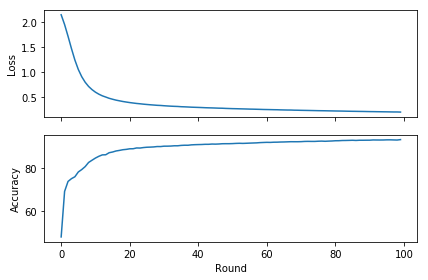

In [61]:
fm.plot(fed_stk95_mgr)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


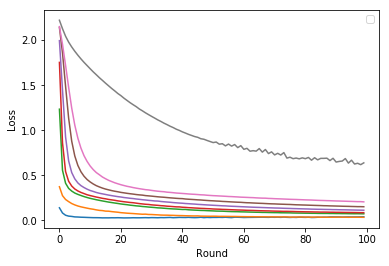

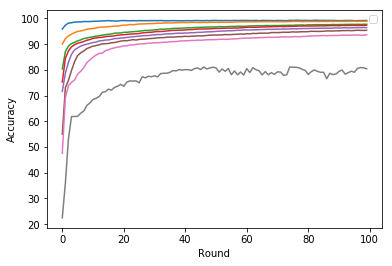

In [72]:
plot_loss([default_manager, 
           fed_constant_n_manager, 
           fed_stk_mgr, 
           fed_stk6_mgr, 
           fed_stk8_mgr, 
           fed_stk90_mgr, 
           fed_stk95_mgr,
           fed_stk10_mgr,
           ])

plot_acc([default_manager, 
           fed_constant_n_manager, 
           fed_stk_mgr, 
           fed_stk6_mgr, 
           fed_stk8_mgr, 
           fed_stk90_mgr, 
           fed_stk95_mgr,
           fed_stk10_mgr,
           ])

In [73]:
fm.main()

Distributions
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


AttributeError: module 'mnist' has no attribute 'Net'

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE